In [1]:
import local_connectivity
from local_connectivity import make_tables, dist, connect_stats, plot
%reload_ext autoreload
%autoreload 2

In [2]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.stats import proportion
import warnings
from tqdm import tqdm

In [3]:
client = CAVEclient(global_only=True)
client = CAVEclient('minnie65_phase3_v1')

In [4]:
presyn_df = ['allen_v1_column_types_slanted']
df = client.materialize.query_table(presyn_df[0],split_positions=True)
df.loc[df['cell_type'] == '6CT', 'cell_type'] = '6P'
df.loc[df['cell_type'] == '6IT', 'cell_type'] = '6P'

/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
pre_root_ids = [864691135428608048]
pree = []
for i in range(len(pre_root_ids)):
    pre_grab = df.query(f"pt_root_id == @pre_root_ids[{i}]")
    pree.append(pre_grab)

In [6]:
np.unique(df.cell_type)

array(['23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6P', 'BC', 'BPC', 'MC',
       'NGC', 'Unsure'], dtype=object)

In [6]:
pre = []
pre_df = df.query("cell_type == 'BC'").reset_index(drop=True)
for i in range(len(pre_df)):
    p = pre_df.iloc[[i]]
    pre.append(p)

In [7]:
len(pre)

45

In [8]:
main,syn,nonsyn = [],[],[]
badroots = []
for i in tqdm(range(len(pre))):
    try:
        m,s,n = make_tables.build_tables(client,pre[i])
        main.append(m)
        syn.append(s)
        nonsyn.append(n)
    except:
        badroots.append(pre[i])
        continue

  0%|                                                    | 0/45 [00:00<?, ?it/s]/var/folders/nm/l50fqsn14416wyl0lh09ckb40000gn/T/ipykernel_56708/1780857866.py:5: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  m,s,n = make_tables.build_tables(client,pre[i])
100%|███████████████████████████████████████████| 45/45 [12:33<00:00, 16.75s/it]


In [9]:
len(badroots)

0

In [19]:
r = 15
up = 400
threshold = 40
main_types,syn_types,nonsyn_types,f_type,s_type = [],[],[],[],[]
main_thresh,syn_thresh,main_types_thresh,syn_types_thresh,f_type_thresh,s_type_thresh = [],[],[],[],[],[]
for i in tqdm(range(len(pre))):
    beh = make_tables.prep_tables(main[i],syn[i],nonsyn[i],r,up)
    main_types.append(beh[0])
    syn_types.append(beh[1])
    nonsyn_types.append(beh[2])
    f_type.append(beh[3])
    s_type.append(beh[4])
    
    bep = make_tables.prep_tables_thresh(main[i],syn[i],r,up,threshold)
    main_thresh.append(bep[0])
    syn_thresh.append(bep[1])
    main_types_thresh.append(bep[2])
    syn_types_thresh.append(bep[3])
    f_type_thresh.append(bep[4])
    s_type_thresh.append(bep[5])

100%|███████████████████████████████████████████| 45/45 [02:39<00:00,  3.55s/it]


In [18]:
plot.makepdfs(client,pre,main,syn_types,nonsyn_types,s_type,f_type,r,up,None)
plot.makepdfs(client,pre,main,syn_types_thresh,nonsyn_types,s_type_thresh,f_type_thresh,r,up,threshold)

100%|███████████████████████████████████████████| 45/45 [05:13<00:00,  6.97s/it]


# Examining Depth

In [25]:
L1 = [296,400]
L23 = [401,588]
L4 = [589,736]
L5 = [736,896]
L6 = [897,1060]
WM = [1061,1146]
depths = np.array((L1,L23,L4,L5,L6,WM))
depth_names = np.array(('L1','L23','L4','L5','L6','WM'))

In [26]:
depth_syn,depth_nonsyn = [],[]
for i in range(len(depths)):
    d_syn,d_non = [],[]
    for j in range(len(syn)):
        m1 = syn[j][((syn[j]['pt_position_y']*(4/1000))<depths[i][1]) & ((syn[j]['pt_position_y']*(4/1000))>depths[i][0])].reset_index(drop=True)
        m2 = nonsyn[j][((nonsyn[j]['pt_position_y']*(4/1000))<depths[i][1]) & ((nonsyn[j]['pt_position_y']*(4/1000))>depths[i][0])].reset_index(drop=True)
        d_syn.append(m1)
        d_non.append(m2)
    depth_syn.append(d_syn)
    depth_nonsyn.append(d_non)

In [27]:
pre[6].pt_position_y.values*(4/1000)

array([882.944])

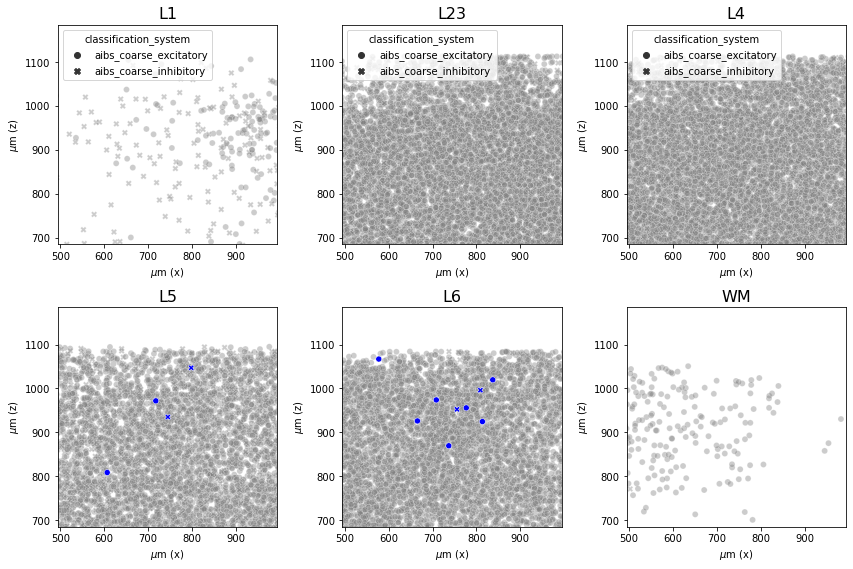

In [28]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,8)

for i in range(len(depths)):
    k=6
    if i < 3:
        sns.scatterplot(data=depth_nonsyn[i][k], x=depth_nonsyn[i][k].pt_position_x*(4/1000), y=depth_nonsyn[i][k].pt_position_z*(40/1000),
                       ax=ax[0,i], color='grey', style = 'classification_system', alpha=.4, legend= True).set_ylabel(r'$\mu$m (z)')
        sns.scatterplot(data=depth_syn[i][k], x=depth_syn[i][k].pt_position_x*(4/1000), y=depth_syn[i][k].pt_position_z*(40/1000),
                       ax=ax[0,i], color='b', style = 'classification_system', alpha=1., legend= False).set_xlabel(r'$\mu$m (x)')
        #sns.scatterplot(x=pre[k].pt_position_x*(4/1000), y=pre[k].pt_position_z*(40/1000), marker='*',color='r',s=200,
        #                ax=ax[0,2], legend= False).set_ylabel(r'$\mu$m')
        xrange = [int(pre[k].pt_position_x*(4/1000))-250,int(pre[k].pt_position_x*(4/1000))+250]
        yrange = [int(pre[k].pt_position_z*(40/1000))-250,int(pre[k].pt_position_z*(40/1000))+250]
        ax[0,i].set_xlim(xrange[0],xrange[1])
        ax[0,i].set_ylim(yrange[0],yrange[1])
        ax[0,i].set_title(depth_names[i],fontsize=16)
        ax[0,i].set_aspect('equal')
    else:
        sns.scatterplot(data=depth_nonsyn[i][k], x=depth_nonsyn[i][k].pt_position_x*(4/1000), y=depth_nonsyn[i][k].pt_position_z*(40/1000),
                       ax=ax[1,i-3], color='grey', style = 'classification_system', alpha=.4, legend= False).set_ylabel(r'$\mu$m (z)')
        sns.scatterplot(data=depth_syn[i][k], x=depth_syn[i][k].pt_position_x*(4/1000), y=depth_syn[i][k].pt_position_z*(40/1000),
                       ax=ax[1,i-3], color='b', style = 'classification_system', alpha=1., legend= False).set_xlabel(r'$\mu$m (x)')
        #sns.scatterplot(x=boy.pt_position_x*(4/1000), y=boy.pt_position_z*(40/1000), marker='*',color='r',s=200,
                        #ax=ax[1,i-3]).set_ylabel(r'$\mu$m')
        xrange = [int(pre[k].pt_position_x*(4/1000))-250,int(pre[k].pt_position_x*(4/1000))+250]
        yrange = [int(pre[k].pt_position_z*(40/1000))-250,int(pre[k].pt_position_z*(40/1000))+250]
        ax[1,i-3].set_xlim(xrange[0],xrange[1])
        ax[1,i-3].set_ylim(yrange[0],yrange[1])
        ax[1,i-3].set_title(depth_names[i],fontsize=16)
        ax[1,i-3].set_aspect('equal')
fig.tight_layout()

In [23]:
osyn,orph_rootids,numosyn = [],[],[]
for i in tqdm(range(len(pre))):
    os,orp,num = make_tables.find_orphans(client,pre[i])
    osyn.append(os)
    orph_rootids.append(orp)
    numosyn.append(num)

100%|███████████████████████████████████████████| 45/45 [02:14<00:00,  2.99s/it]


In [24]:
numb,numbsyn = [],[]
n_oroots = []
for i in range(len(syn)):
    numb.append(len(syn[i]))
    numbsyn.append(sum(syn[i].num_syn))
    n_oroots.append(len(orph_rootids[i]))

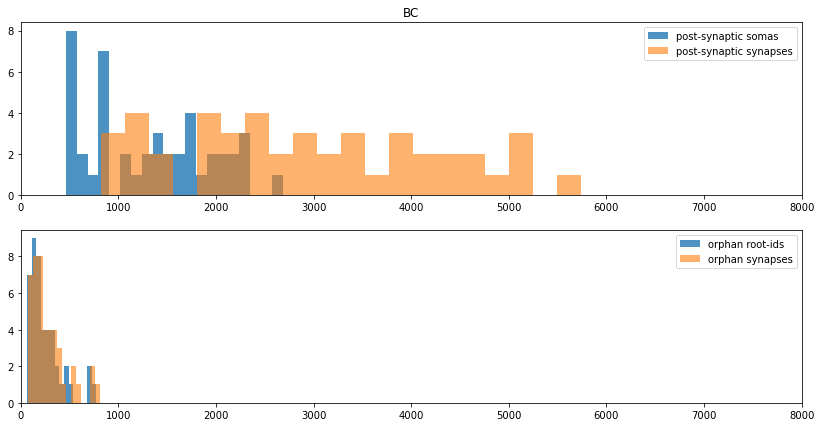

In [25]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(14,7)

ax[0].hist(numb, 20, density=False, alpha=.8, label='post-synaptic somas')
ax[0].hist(numbsyn, 20, density=False, alpha=.6, label='post-synaptic synapses')
ax[0].set_title(pre[0].cell_type.values[0])
#ax[0].grid()
ax[0].legend()

ax[1].hist(n_oroots, 15, density=False, alpha=.8, label='orphan root-ids')
ax[1].hist(numosyn, 15, density=False, alpha=.6, label='orphan synapses')
#ax[1].grid()
ax[1].legend()

ax[0].set_xlim(0,8000)
ax[1].set_xlim(0,8000)
plt.show()

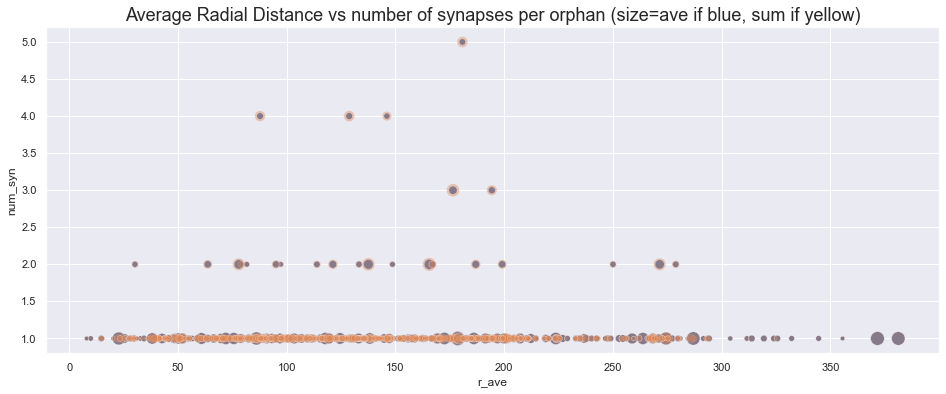

In [26]:
sns.set(rc={'figure.figsize':(16,6)})
g = sns.scatterplot(data=osyn[0],x='r_ave',y='num_syn',size='ave_size', sizes=(20, 200), legend= False);
sns.scatterplot(data=osyn[0],x='r_ave',y='num_syn',size='sum_size', sizes=(20, 200), legend= False, alpha=.4)
#g.set(xlim=(0, 250));
#g.set(ylim=(0, 20));
g.set_title('Average Radial Distance vs number of synapses per orphan (size=ave if blue, sum if yellow)', fontsize=18);

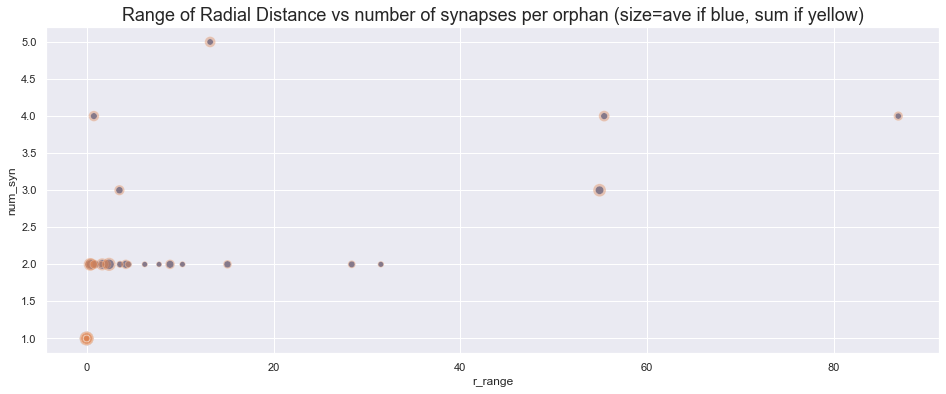

In [27]:
sns.set(rc={'figure.figsize':(16,6)})
g = sns.scatterplot(data=osyn[0],x='r_range',y='num_syn',size='ave_size', sizes=(20, 200), legend= False);
sns.scatterplot(data=osyn[0],x='r_range',y='num_syn',size='sum_size', sizes=(20, 200), legend= False, alpha=.4)
#sns.scatterplot(data=osyn,x='d_ave',y='num_syn',size='ave_size', sizes=(20, 200), legend= False)
#g.set(xlim=(0, 250));
#g.set(ylim=(0, 20));
g.set_title('Range of Radial Distance vs number of synapses per orphan (size=ave if blue, sum if yellow)', fontsize=18);

In [28]:
ox,oy,oz = [],[],[]
ox_diff,oy_diff,oz_diff = [],[],[]
synx_diff,syny_diff,synz_diff = [],[],[]
ox_ave,oy_ave,oz_ave = [],[],[]
synx_ave,syny_ave,synz_ave = [],[],[]
for i in range(len(osyn)):
    xx,yy,zz = [],[],[]
    for j in range(len(osyn[i])):
        x = osyn[i].ctr_pt_position[j][0][0]*(4/1000)
        y = osyn[i].ctr_pt_position[j][0][1]*(4/1000)
        z = osyn[i].ctr_pt_position[j][0][2]*(40/1000)
        xx.append(x)
        yy.append(y)
        zz.append(z)
    ox.append(xx)
    oy.append(yy)
    oz.append(zz)
    ox_diff.append(np.abs(xx-np.array(pre[i]['pt_position_x']*(4/1000))[0]))
    oy_diff.append(np.abs(yy-np.array(pre[i]['pt_position_y']*(4/1000))[0]))
    oz_diff.append(np.abs(zz-np.array(pre[i]['pt_position_z']*(40/1000))[0]))
    synx_diff.append(np.abs(syn[i]['pt_position_x']*(4/1000)-np.array(pre[i]['pt_position_x']*(4/1000))[0]))
    syny_diff.append(np.abs(syn[i]['pt_position_y']*(4/1000)-np.array(pre[i]['pt_position_y']*(4/1000))[0]))
    synz_diff.append(np.abs(syn[i]['pt_position_z']*(40/1000)-np.array(pre[i]['pt_position_z']*(40/1000))[0]))
    ox_ave.append(np.average(ox_diff[i]))
    oy_ave.append(np.average(oy_diff[i]))
    oz_ave.append(np.average(oz_diff[i]))
    synx_ave.append(np.average(synx_diff[i]))
    syny_ave.append(np.average(syny_diff[i]))
    synz_ave.append(np.average(synz_diff[i]))

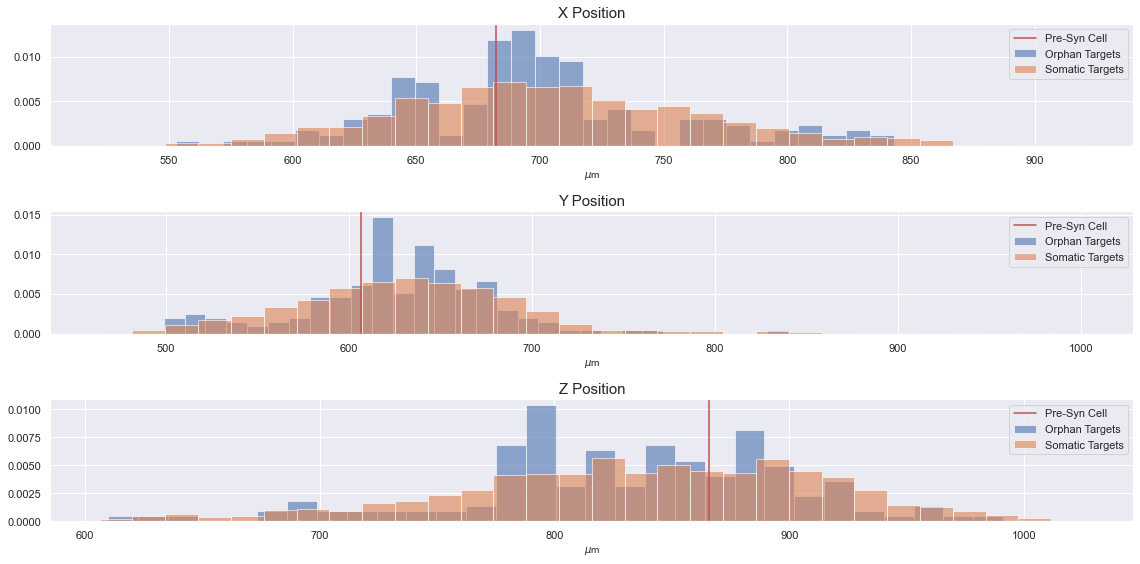

In [29]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(16,8)
k = 3

ax[0].hist(ox[k], 30, label='Orphan Targets', density=True, alpha=0.6)
ax[0].hist(syn[k]['pt_position_x']*(4/1000), 30, label='Somatic Targets', density=True, alpha=0.6)
ax[0].axvline(np.array(pre[k]['pt_position_x']*(4/1000))[0], label='Pre-Syn Cell', c='r')
ax[0].set_title("X Position", fontsize=15)
ax[0].set_xlabel(r'$\mu$m', fontsize=10)
ax[0].legend()

ax[1].hist(oy[k], 30, label='Orphan Targets', density=True, alpha=0.6)
ax[1].hist(syn[k]['pt_position_y']*(4/1000), 30, label='Somatic Targets', density=True, alpha=0.6)
ax[1].axvline(np.array(pre[k]['pt_position_y']*(4/1000))[0], label='Pre-Syn Cell', c='r')
ax[1].set_title("Y Position", fontsize=15)
ax[1].set_xlabel(r'$\mu$m', fontsize=10)
ax[1].legend()

ax[2].hist(oz[k], 30, label='Orphan Targets', density=True, alpha=0.6)
ax[2].hist(syn[k]['pt_position_z']*(40/1000), 30, label='Somatic Targets', density=True, alpha=0.6)
ax[2].axvline(np.array(pre[k]['pt_position_z']*(40/1000))[0], label='Pre-Syn Cell', c='r')
ax[2].set_title("Z Position", fontsize=15)
ax[2].set_xlabel(r'$\mu$m', fontsize=10)
ax[2].legend()

plt.tight_layout()
plt.show()

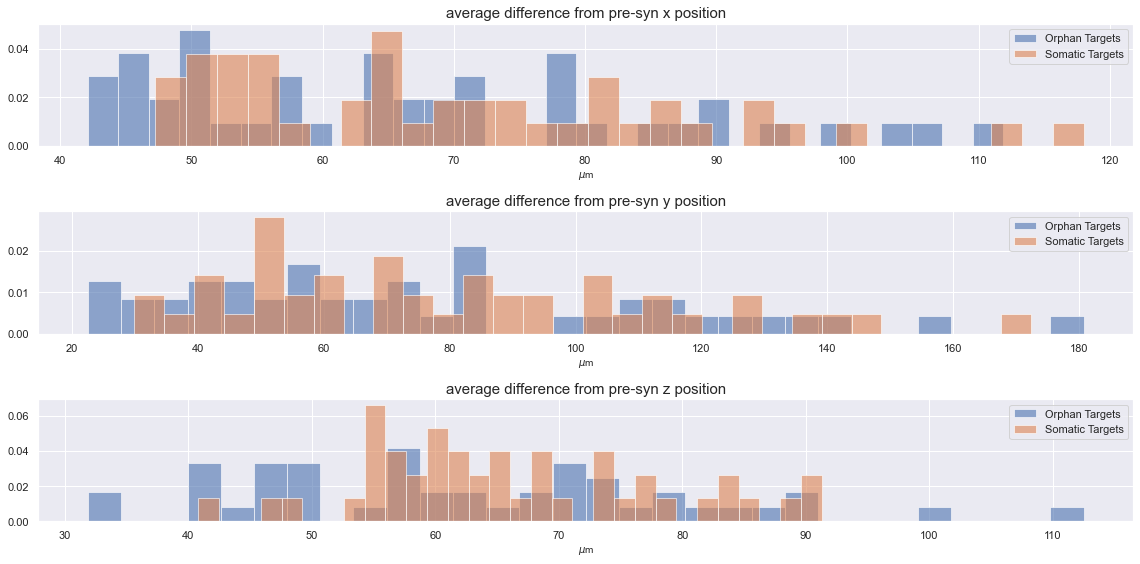

In [30]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(16,8)

ax[0].hist(ox_ave, 30, label='Orphan Targets', density=True, alpha=0.6)
ax[0].hist(synx_ave, 30, label='Somatic Targets', density=True, alpha=0.6)
ax[0].set_title("average difference from pre-syn x position", fontsize=15)
ax[0].set_xlabel(r'$\mu$m', fontsize=10)
ax[0].legend()

ax[1].hist(oy_ave, 30, label='Orphan Targets', density=True, alpha=0.6)
ax[1].hist(syny_ave, 30, label='Somatic Targets', density=True, alpha=0.6)
ax[1].set_title("average difference from pre-syn y position", fontsize=15)
ax[1].set_xlabel(r'$\mu$m', fontsize=10)
ax[1].legend()

ax[2].hist(oz_ave, 30, label='Orphan Targets', density=True, alpha=0.6)
ax[2].hist(synz_ave, 30, label='Somatic Targets', density=True, alpha=0.6)
ax[2].set_title("average difference from pre-syn z position", fontsize=15)
ax[2].set_xlabel(r'$\mu$m', fontsize=10)
ax[2].legend()

plt.tight_layout()
plt.show()

In [43]:
# o = []
# bad_oroots = []
# for i in tqdm(range(len(orph_rootids))):
#     o_per_presyn = []
#     for j in range(len(orph_rootids[i])):
#         try:
#             orphans = client.materialize.query_table('synapses_pni_2',
#                                                      select_columns=['pre_pt_root_id','post_pt_root_id','size','ctr_pt_position'],
#                                                        filter_equal_dict={'post_pt_root_id':orph_rootids[i][j][0]})
#             o_per_presyn.append(orphans)
#         except:
#             bad_oroots.append(orph_rootids[i][j][0])
#     o.append(o_per_presyn)

In [40]:
# len(bad_oroots)

In [41]:
# o_df = []
# for i in range(len(o)):
#     bep = pd.concat(o[i],ignore_index=True)
#     o_df.append(bep)

In [42]:
# for i in tqdm(range(len(o_df))):
#     o_df[i].to_pickle("./orphans/{0:s}{1:s}-orphans.pkl".format(str(pre[0].cell_type.values[0]),str(i)))

In [97]:
o_dup = []
for i in range(len(orph_rootids)):
    beep = pd.read_pickle('./orphans/{0:s}{1:s}-orphans.pkl'.format(str(pre[0].cell_type.values[0]),str(i)))
    o_dup.append(beep)

In [98]:
def prep_orphans(o_dup,pre_df):
    o_dup = o_dup.sort_values(by=['post_pt_root_id']).reset_index(drop=True)
    o_dup['num_syn'] = o_dup.groupby('post_pt_root_id')['post_pt_root_id'].transform('count')
    o_dup.rename(columns={'size':'sizes'}, inplace=True)
    o = o_dup.drop_duplicates(subset='post_pt_root_id', keep='first').reset_index(drop=True)
    o['pre_pt_root_id'] = o_dup.assign(pre_pt_root_id=tuple(o_dup.pre_pt_root_id)).groupby('post_pt_root_id').pre_pt_root_id.apply(list).reset_index(drop=True)
    o['ctr_pt_position'] = o_dup.assign(ctr_pt_position=tuple(o_dup.ctr_pt_position)).groupby('post_pt_root_id').ctr_pt_position.apply(list).reset_index(drop=True)
    o['sizes'] = o_dup.assign(sizes=tuple(o_dup.sizes)).groupby('post_pt_root_id').sizes.apply(list).reset_index(drop=True)
    return o

In [99]:
o = []
for i in tqdm(range(len(o_dup))):
    beh = prep_orphans(o_dup[i],pre[i])
    o.append(beh)

100%|███████████████████████████████████████████| 30/30 [00:01<00:00, 19.05it/s]


In [100]:
o[0][0:1]

,pre_pt_root_id,post_pt_root_id,sizes,ctr_pt_position,num_syn
0,"[864691135491415647, 864691136724555118]",864691133005486261,"[3492, 5184]","[[181086, 169278, 21397], [181014, 169218, 213...",2


In [101]:
allox,alloy,alloz = [],[],[]
for i in range(len(osyn)):
    xx,yy,zz = [],[],[]
    for j in range(len(osyn[i])):
        x = o[i].ctr_pt_position[j][0][0]*(4/1000)
        y = o[i].ctr_pt_position[j][0][1]*(4/1000)
        z = o[i].ctr_pt_position[j][0][2]*(40/1000)
        xx.append(x)
        yy.append(y)
        zz.append(z)
    allox.append(xx)
    alloy.append(yy)
    alloz.append(zz)

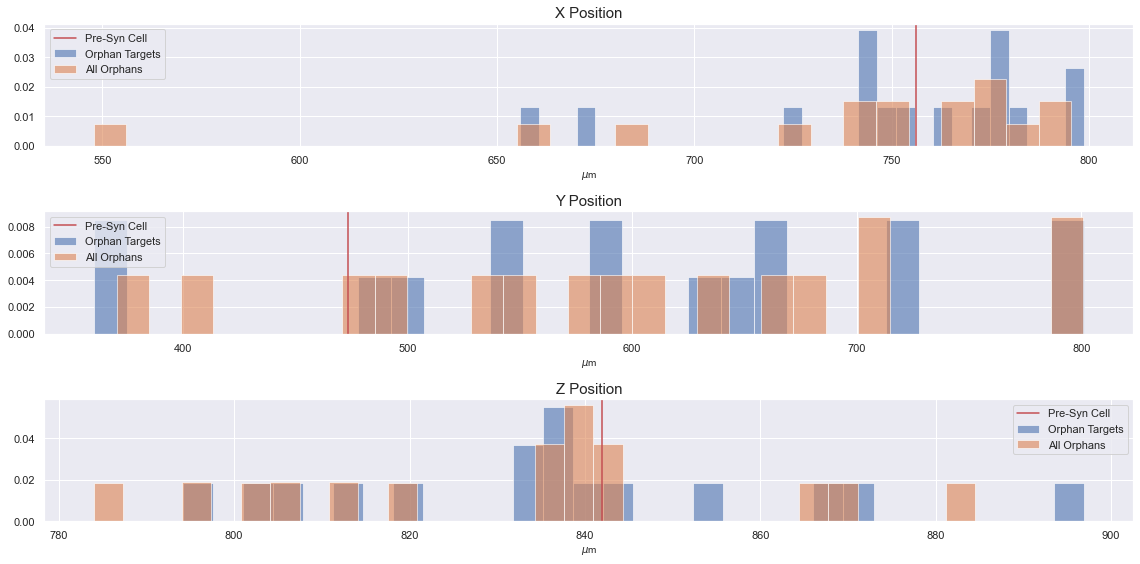

In [102]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(16,8)
k = 3

ax[0].hist(ox[k], 30, label='Orphan Targets', density=True, alpha=0.6)
ax[0].hist(allox[k], 30, label='All Orphans', density=True, alpha=0.6)
ax[0].axvline(np.array(pre[k]['pt_position_x']*(4/1000))[0], label='Pre-Syn Cell', c='r')
ax[0].set_title("X Position", fontsize=15)
ax[0].set_xlabel(r'$\mu$m', fontsize=10)
ax[0].legend()

ax[1].hist(oy[k], 30, label='Orphan Targets', density=True, alpha=0.6)
ax[1].hist(alloy[k], 30, label='All Orphans', density=True, alpha=0.6)
ax[1].axvline(np.array(pre[k]['pt_position_y']*(4/1000))[0], label='Pre-Syn Cell', c='r')
ax[1].set_title("Y Position", fontsize=15)
ax[1].set_xlabel(r'$\mu$m', fontsize=10)
ax[1].legend()

ax[2].hist(oz[k], 30, label='Orphan Targets', density=True, alpha=0.6)
ax[2].hist(alloz[k], 30, label='All Orphans', density=True, alpha=0.6)
ax[2].axvline(np.array(pre[k]['pt_position_z']*(40/1000))[0], label='Pre-Syn Cell', c='r')
ax[2].set_title("Z Position", fontsize=15)
ax[2].set_xlabel(r'$\mu$m', fontsize=10)
ax[2].legend()

plt.tight_layout()
plt.show()

- ~array of distances for synapse to target (and synapse to pre_syn)~
- ~make the same plots but only for synapses within 40 µm of their target cell body position~
- ~grab all my bullshit from minnie~
- quantify orphan targets, add uncertainty OR assign to excitatory?
- make the same plots but scale color w snapse count
- add ave synapse size to depth vs radial distance plots
- remake demo notebook
- distribution of total number of synapses from the starter cell onto those cells per cell type
- calculate angle to target cells from pre_synaptic cell / determine axon angle
- measure drop-off of axon/dendrite overlap

- normalize hist?
- target cell's synapse position info? spread? volume?

### From Casey:

Orphans will happen, in principle, when the root id does not show up in the nucleus_neuron_svm table. 

There are two basic possibilities for an orphan:
1. The orphan should connect to a cell in the dataset but there is an error in the segmentation that needs proofreading
2. The orphan is a true orphan, part of a cell outside the dataset volume.

For our measurements, Category 1 breaks down into more cateogries:

    1a) Other synapses from the orphan's true host are accounted for, so the orphan will only add to the synapse count
    
    1b) The segmented cell does not receive other synapses from the seed interneuron, and thus there is a false lack of connection in the data until the orphan is attached.

These all will have spatial biases (more orphans close to the dataset edge) and morphology biases (neurons that target cell bodies might have fewer orphans of type 1b, because dendrite fragments tend to start farther out on the cell)

I suspect we will have to actually do some manual counting of these, in order to quantify our uncertainty